# 深度学习方法

In [2]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

In [3]:
os.listdir('.')

['deep.ipynb',
 'result',
 '.DS_Store',
 'dataset',
 'notebook.ipynb',
 'predict.py',
 '.gitignore',
 '.git',
 '.idea']

In [165]:
baseinfo = pd.read_csv('dataset/1baseinfo.csv')

train_labels = pd.read_csv('dataset/train.csv')

test_data = pd.read_csv('dataset/evaluation_public.csv')

invest_data = pd.read_csv('dataset/4investinfo.csv')

invest_data = invest_data[invest_data.Sharehold != 0.0]

invest_data['Sharehold'] = invest_data['Sharehold'].fillna(0).astype('float32')
invest_data['InvestRegYear'] = invest_data['InvestRegYear'].fillna(1970).astype('int')
invest_data['InvestCloseYear'] = invest_data['InvestCloseYear'].fillna(2050).astype('int')

invest_same_province_count = invest_data.copy()
invest_same_province_count = invest_same_province_count[['EID', 'SameProvince']].groupby(['EID']).sum()

invest_share_hold_sum = invest_data.copy()
invest_share_hold_sum = invest_share_hold_sum[['EID', 'Sharehold']].groupby(['EID']).sum()

invest_start_date_sum = invest_data.copy()
invest_start_date_sum = invest_start_date_sum[['EID', 'InvestRegYear']].groupby(['EID']).sum()

invest_end_date_sum = invest_data.copy()
invest_end_date_sum = invest_end_date_sum[['EID', 'InvestCloseYear']].groupby(['EID']).sum()

invest_end_date_sum.head()

invest_data = invest_data[['EID']].groupby(['EID']).size().reset_index(name='hold_share_counts')
invest_data['hold_share_counts'] = invest_data['hold_share_counts'].fillna(0).astype('int')

invest_data = pd.merge(invest_data, invest_end_date_sum, on='EID', how='left')
invest_data = pd.merge(invest_data, invest_start_date_sum, on='EID', how='left')  
invest_data = pd.merge(invest_data, invest_share_hold_sum, on='EID', how='left')
invest_data = pd.merge(invest_data, invest_same_province_count, on='EID', how='left')


invest_data.head()


,EID,hold_share_counts,InvestCloseYear,InvestRegYear,Sharehold,SameProvince
0,99514,1,2050,1996,1.000,1
1,103798,1,2050,2003,0.850,1
2,125132,1,2050,2010,0.068,1
3,125135,2,4100,4025,1.300,0
4,127718,1,2050,2012,0.158,1


In [166]:
## 处理分支机构表

branch_data = pd.read_csv('dataset/3branchinfo.csv')

branch_data['CloseYear'] = branch_data['CloseYear'].fillna(2050).astype('int')

branch_count = branch_data[['EID']].groupby(['EID']).size().reset_index(name='branch_count')

invest_data = pd.merge(invest_data, branch_count, on='EID', how='left')

invest_data['branch_count'] = invest_data['branch_count'].fillna(0).astype('int')

invest_data.head(20)


,EID,hold_share_counts,InvestCloseYear,InvestRegYear,Sharehold,SameProvince,branch_count
0,99514,1,2050,1996,1.000,1,0
1,103798,1,2050,2003,0.850,1,4
2,125132,1,2050,2010,0.068,1,0
3,125135,2,4100,4025,1.300,0,0
4,127718,1,2050,2012,0.158,1,0
5,127815,2,4056,3981,2.000,1,0
6,151436,1,2050,2013,0.102,0,0
7,190622,1,2050,2012,0.462,1,0
8,190672,8,16400,16072,4.783,8,2
9,224594,1,2050,2012,1.000,0,0


In [189]:

baseinfo['EID'] = baseinfo['EID'].fillna(0)
baseinfo['CreateYear'] = baseinfo['CreateYear'].fillna(0)
baseinfo['TradeType'] = baseinfo['TradeType'].fillna(0).astype('int')
baseinfo['RegisteredCapital'] = baseinfo['RegisteredCapital'].fillna(0).astype('int')
baseinfo['Feature1'] = baseinfo['Feature1'].fillna(0)
baseinfo['Feature2'] = baseinfo['Feature2'].fillna(0)
baseinfo['Feature3'] = baseinfo['Feature3'].fillna(0)
baseinfo['Feature4'] = baseinfo['Feature4'].fillna(0)
baseinfo['Feature5'] = baseinfo['Feature5'].fillna(0)
train_labels['EndDate'] = train_labels['EndDate'].fillna('0').astype('int')

merged_train = pd.merge(baseinfo,invest_data,on='EID',how='left')
merged_train = pd.merge(merged_train, train_labels, on='EID', how='right')
merged_train['hold_share_counts'] = merged_train['hold_share_counts'].fillna(0).astype('int')
merged_train['Sharehold'] = merged_train['Sharehold'].fillna(0.0).astype('float32')
merged_train['InvestCloseYear'] = merged_train['InvestCloseYear'].fillna(0).astype('int')
merged_train['SameProvince'] = merged_train['SameProvince'].fillna(0).astype('int')
merged_train['InvestRegYear'] = merged_train['InvestRegYear'].fillna(0).astype('int')
merged_train['branch_count'] = merged_train['branch_count'].fillna(0).astype('int')

print(len(merged_train))

print(merged_train.head(10))


150095
          EID  CreateYear  TradeType  RegisteredCapital  Type  Feature1  \
0   732046267        1980         51                480    13      25.0   
1  1338267101        2005         74                240     5       0.0   
2  1057042610        2011         75               3000     6       4.0   
3   400121247        1982         55               1000     6       9.0   
4   970179772        1986         53                150    17       4.0   
5  1130660041        2004         51                500     6       3.0   
6   371689898        2010         70               2000     6      25.0   
7   647710623        2010         72              10100    16       0.0   
8  1161140889        1989         54                100     6       2.0   
9    92459160        2007         39                100     6       1.0   

   Feature2  Feature3  Feature4  Feature5  hold_share_counts  InvestCloseYear  \
0       1.0   98041.0      17.0       0.0                  3             6060   
1    

In [170]:
dim = 15 + 1

train_x = merged_train.iloc[:, 1:dim]

train_y = merged_train.iloc[:, dim:dim + 1]

train_x.head()


,CreateYear,TradeType,RegisteredCapital,Type,Feature1,Feature2,Feature3,Feature4,Feature5,hold_share_counts,InvestCloseYear,InvestRegYear,Sharehold,SameProvince,branch_count
0,1980,51,480,13,25.0,1.0,98041.0,17.0,0.0,3,6060,5959,1.65,2,0
1,2005,74,240,5,0.0,2.0,1500.0,0.0,0.0,0,0,0,0.00,0,0
2,2011,75,3000,6,4.0,8.0,10500.0,13.0,0.0,3,6150,6043,2.75,0,0
3,1982,55,1000,6,9.0,2.0,619318.0,31.0,0.0,6,12300,11907,4.04,6,0
4,1986,53,150,17,4.0,1.0,13000.0,31.0,0.0,0,0,0,0.00,0,0


In [172]:
merged_test = pd.merge(baseinfo, invest_data, on='EID', how='left')
merged_test = pd.merge(merged_test, test_data, on='EID', how='right')
merged_test['hold_share_counts'] = merged_test['hold_share_counts'].fillna(0).astype('int')
merged_test['Sharehold'] = merged_test['Sharehold'].fillna(0.0).astype('float')
merged_test['InvestCloseYear'] = merged_test['InvestCloseYear'].fillna(0).astype('int')
merged_test['SameProvince'] = merged_test['SameProvince'].fillna(0).astype('int')
merged_test['InvestRegYear'] = merged_test['InvestRegYear'].fillna(0).astype('int')
merged_test['branch_count'] = merged_test['branch_count'].fillna(0).astype('int')

test_x = merged_test.iloc[:, 1:dim]
test_y = merged_test.iloc[:, dim:dim + 1]


test_x.head()



,CreateYear,TradeType,RegisteredCapital,Type,Feature1,Feature2,Feature3,Feature4,Feature5,hold_share_counts,InvestCloseYear,InvestRegYear,Sharehold,SameProvince,branch_count
0,1993,74,30,13,0.0,1.0,570.0,3.0,0.0,0,0,0,0.000,0,0
1,2015,69,1000,6,2.0,1.0,1000.0,0.0,0.0,0,0,0,0.000,0,0
2,1995,54,14200,5,0.0,2.0,11280.0,5.0,0.0,3,6150,6027,1.800,2,3
3,2002,48,2800,7,0.0,22.0,100.0,0.0,0.0,1,2050,1983,0.118,1,1
4,2015,51,7000,6,3.0,2.0,909980.0,12.0,0.0,0,0,0,0.000,0,0


In [173]:
train_x = sequence.pad_sequences(train_x.values)
train_y = sequence.pad_sequences(train_y.values)

print(train_x.shape)
print(train_y.shape)


(150095, 15)
(150095, 1)


In [213]:
model = Sequential()

model.add(Dense(20, activation='softmax', input_dim=dim - 1))
model.add(Dense(16, activation='tanh'))
model.add(Dense(15, activation='relu'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(15, activation='relu'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# 二分类问题
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_x, train_y,
          validation_split=0.1,
          batch_size=64,
          epochs=5,
          )

model.evaluate(train_x, train_y)

## 计算AUC

from sklearn import metrics

train_pred_y = model.predict(train_x)

auc = metrics.roc_auc_score(train_y, train_pred_y)

print(auc)


Train on 135085 samples, validate on 15010 samples
Epoch 1/5


    64/135085 [..............................] - ETA: 1:39:52 - loss: 0.4518 - acc: 0.8750

   704/135085 [..............................] - ETA: 9:12 - loss: 0.4097 - acc: 0.8793   

  1344/135085 [..............................] - ETA: 4:53 - loss: 0.4160 - acc: 0.8653

  2048/135085 [..............................] - ETA: 3:14 - loss: 0.3963 - acc: 0.8721

  2688/135085 [..............................] - ETA: 2:30 - loss: 0.4030 - acc: 0.8672

  3520/135085 [..............................] - ETA: 1:55 - loss: 0.4069 - acc: 0.8636

  4352/135085 [..............................] - ETA: 1:34 - loss: 0.4021 - acc: 0.8656

  5248/135085 [>.............................] - ETA: 1:19 - loss: 0.4021 - acc: 0.8649

  6144/135085 [>.............................] - ETA: 1:08 - loss: 0.3990 - acc: 0.8660

  6976/135085 [>.............................] - ETA: 1:00 - loss: 0.4027 - acc: 0.8637

  7808/135085 [>.............................] - ETA: 54s - loss: 0.4024 - acc: 0.8636 

  8640/135085 [>.............................] - ETA: 49s - loss: 0.3986 - acc: 0.8654

  9536/135085 [=>............................] - ETA: 45s - loss: 0.4020 - acc: 0.8635

 10368/135085 [=>............................] - ETA: 42s - loss: 0.4018 - acc: 0.8633

 11136/135085 [=>............................] - ETA: 39s - loss: 0.4007 - acc: 0.8639

 11968/135085 [=>............................] - ETA: 37s - loss: 0.3988 - acc: 0.8647

 12992/135085 [=>............................] - ETA: 34s - loss: 0.4002 - acc: 0.8638

 13952/135085 [==>...........................] - ETA: 32s - loss: 0.4025 - acc: 0.8624

 14912/135085 [==>...........................] - ETA: 30s - loss: 0.4037 - acc: 0.8615

 15808/135085 [==>...........................] - ETA: 28s - loss: 0.4023 - acc: 0.8623

 16704/135085 [==>...........................] - ETA: 27s - loss: 0.4005 - acc: 0.8632

 17664/135085 [==>...........................] - ETA: 26s - loss: 0.4013 - acc: 0.8627

 18560/135085 [===>..........................] - ETA: 25s - loss: 0.4021 - acc: 0.8622



 19456/135085 [===>..........................] - ETA: 23s - loss: 0.4020 - acc: 0.8624

 20224/135085 [===>..........................] - ETA: 23s - loss: 0.4011 - acc: 0.8628

 21120/135085 [===>..........................] - ETA: 22s - loss: 0.4013 - acc: 0.8627

 22016/135085 [===>..........................] - ETA: 21s - loss: 0.4017 - acc: 0.8625

 22912/135085 [====>.........................] - ETA: 20s - loss: 0.4019 - acc: 0.8623

 23744/135085 [====>.........................] - ETA: 20s - loss: 0.4018 - acc: 0.8623

 24640/135085 [====>.........................] - ETA: 19s - loss: 0.4014 - acc: 0.8625

 25536/135085 [====>.........................] - ETA: 18s - loss: 0.4009 - acc: 0.8627

 26368/135085 [====>.........................] - ETA: 18s - loss: 0.4017 - acc: 0.8623

 27136/135085 [=====>........................] - ETA: 17s - loss: 0.4001 - acc: 0.8631

 27968/135085 [=====>........................] - ETA: 17s - loss: 0.3990 - acc: 0.8637

 28800/135085 [=====>........................] - ETA: 16s - loss: 0.3996 - acc: 0.8633

 29696/135085 [=====>........................] - ETA: 16s - loss: 0.3992 - acc: 0.8636

 30592/135085 [=====>........................] - ETA: 16s - loss: 0.3995 - acc: 0.8634

 31488/135085 [=====>........................] - ETA: 15s - loss: 0.3994 - acc: 0.8634

 32384/135085 [======>.......................] - ETA: 15s - loss: 0.3989 - acc: 0.8636

 33216/135085 [======>.......................] - ETA: 14s - loss: 0.3985 - acc: 0.8639

 33920/135085 [======>.......................] - ETA: 14s - loss: 0.3980 - acc: 0.8641

 34752/135085 [======>.......................] - ETA: 14s - loss: 0.3984 - acc: 0.8639

 35648/135085 [======>.......................] - ETA: 13s - loss: 0.3983 - acc: 0.8639

 36544/135085 [=======>......................] - ETA: 13s - loss: 0.3972 - acc: 0.8645

 37376/135085 [=======>......................] - ETA: 13s - loss: 0.3969 - acc: 0.8646

 38208/135085 [=======>......................] - ETA: 13s - loss: 0.3968 - acc: 0.8647

 39104/135085 [=======>......................] - ETA: 12s - loss: 0.3969 - acc: 0.8646

 40000/135085 [=======>......................] - ETA: 12s - loss: 0.3972 - acc: 0.8644

 40832/135085 [========>.....................] - ETA: 12s - loss: 0.3974 - acc: 0.8642

 41600/135085 [========>.....................] - ETA: 12s - loss: 0.3966 - acc: 0.8647

 42560/135085 [========>.....................] - ETA: 11s - loss: 0.3966 - acc: 0.8646

 43392/135085 [========>.....................] - ETA: 11s - loss: 0.3974 - acc: 0.8642

 44224/135085 [========>.....................] - ETA: 11s - loss: 0.3977 - acc: 0.8640

 44736/135085 [========>.....................] - ETA: 11s - loss: 0.3976 - acc: 0.8640

 45120/135085 [=========>....................] - ETA: 11s - loss: 0.3979 - acc: 0.8639

 45824/135085 [=========>....................] - ETA: 11s - loss: 0.3978 - acc: 0.8639

 46656/135085 [=========>....................] - ETA: 10s - loss: 0.3986 - acc: 0.8635

 47552/135085 [=========>....................] - ETA: 10s - loss: 0.3991 - acc: 0.8632

 48512/135085 [=========>....................] - ETA: 10s - loss: 0.3990 - acc: 0.8633

 49472/135085 [=========>....................] - ETA: 10s - loss: 0.3987 - acc: 0.8635

 50432/135085 [==========>...................] - ETA: 10s - loss: 0.3994 - acc: 0.8631

 51328/135085 [==========>...................] - ETA: 9s - loss: 0.3994 - acc: 0.8631 

 52224/135085 [==========>...................] - ETA: 9s - loss: 0.3991 - acc: 0.8632

 52992/135085 [==========>...................] - ETA: 9s - loss: 0.3986 - acc: 0.8635

 53760/135085 [==========>...................] - ETA: 9s - loss: 0.3987 - acc: 0.8634

 54592/135085 [===========>..................] - ETA: 9s - loss: 0.3986 - acc: 0.8635

 55424/135085 [===========>..................] - ETA: 9s - loss: 0.3987 - acc: 0.8634

 56192/135085 [===========>..................] - ETA: 8s - loss: 0.3985 - acc: 0.8636

 57024/135085 [===========>..................] - ETA: 8s - loss: 0.3984 - acc: 0.8636

 57792/135085 [===========>..................] - ETA: 8s - loss: 0.3981 - acc: 0.8638

 58560/135085 [============>.................] - ETA: 8s - loss: 0.3980 - acc: 0.8638

 59328/135085 [============>.................] - ETA: 8s - loss: 0.3971 - acc: 0.8643

 60160/135085 [============>.................] - ETA: 8s - loss: 0.3972 - acc: 0.8643

 60992/135085 [============>.................] - ETA: 8s - loss: 0.3973 - acc: 0.8642

 61888/135085 [============>.................] - ETA: 7s - loss: 0.3976 - acc: 0.8640

 62848/135085 [============>.................] - ETA: 7s - loss: 0.3973 - acc: 0.8642

 63808/135085 [=============>................] - ETA: 7s - loss: 0.3976 - acc: 0.8640

 64768/135085 [=============>................] - ETA: 7s - loss: 0.3975 - acc: 0.8641

 65664/135085 [=============>................] - ETA: 7s - loss: 0.3973 - acc: 0.8642

 66560/135085 [=============>................] - ETA: 7s - loss: 0.3966 - acc: 0.8645

 67392/135085 [=============>................] - ETA: 7s - loss: 0.3961 - acc: 0.8648

 68224/135085 [==============>...............] - ETA: 6s - loss: 0.3959 - acc: 0.8649

 69056/135085 [==============>...............] - ETA: 6s - loss: 0.3955 - acc: 0.8651

 69888/135085 [==============>...............] - ETA: 6s - loss: 0.3960 - acc: 0.8648

 70784/135085 [==============>...............] - ETA: 6s - loss: 0.3962 - acc: 0.8647

 71616/135085 [==============>...............] - ETA: 6s - loss: 0.3964 - acc: 0.8646

 72448/135085 [===============>..............] - ETA: 6s - loss: 0.3964 - acc: 0.8646

 73280/135085 [===============>..............] - ETA: 6s - loss: 0.3964 - acc: 0.8646

 74048/135085 [===============>..............] - ETA: 6s - loss: 0.3961 - acc: 0.8647

 74880/135085 [===============>..............] - ETA: 5s - loss: 0.3960 - acc: 0.8648

 75712/135085 [===============>..............] - ETA: 5s - loss: 0.3958 - acc: 0.8649

 76544/135085 [===============>..............] - ETA: 5s - loss: 0.3956 - acc: 0.8650

 77376/135085 [================>.............] - ETA: 5s - loss: 0.3958 - acc: 0.8649

 78208/135085 [================>.............] - ETA: 5s - loss: 0.3956 - acc: 0.8650

 79040/135085 [================>.............] - ETA: 5s - loss: 0.3954 - acc: 0.8651

 79936/135085 [================>.............] - ETA: 5s - loss: 0.3951 - acc: 0.8652

 80832/135085 [================>.............] - ETA: 5s - loss: 0.3949 - acc: 0.8653

 81728/135085 [=================>............] - ETA: 5s - loss: 0.3946 - acc: 0.8655

 82624/135085 [=================>............] - ETA: 5s - loss: 0.3948 - acc: 0.8654

 83520/135085 [=================>............] - ETA: 4s - loss: 0.3950 - acc: 0.8653

 84416/135085 [=================>............] - ETA: 4s - loss: 0.3949 - acc: 0.8653

 85312/135085 [=================>............] - ETA: 4s - loss: 0.3947 - acc: 0.8654

 86144/135085 [==================>...........] - ETA: 4s - loss: 0.3946 - acc: 0.8655

 86976/135085 [==================>...........] - ETA: 4s - loss: 0.3945 - acc: 0.8656

 87808/135085 [==================>...........] - ETA: 4s - loss: 0.3947 - acc: 0.8654

 88640/135085 [==================>...........] - ETA: 4s - loss: 0.3953 - acc: 0.8651

 89408/135085 [==================>...........] - ETA: 4s - loss: 0.3954 - acc: 0.8650

 90240/135085 [===================>..........] - ETA: 4s - loss: 0.3953 - acc: 0.8651

 91072/135085 [===================>..........] - ETA: 4s - loss: 0.3952 - acc: 0.8651

 91776/135085 [===================>..........] - ETA: 4s - loss: 0.3951 - acc: 0.8652

 92608/135085 [===================>..........] - ETA: 3s - loss: 0.3949 - acc: 0.8653

 93440/135085 [===================>..........] - ETA: 3s - loss: 0.3950 - acc: 0.8652

 94336/135085 [===================>..........] - ETA: 3s - loss: 0.3951 - acc: 0.8652

 95232/135085 [====================>.........] - ETA: 3s - loss: 0.3953 - acc: 0.8651

 96128/135085 [====================>.........] - ETA: 3s - loss: 0.3952 - acc: 0.8651

 96896/135085 [====================>.........] - ETA: 3s - loss: 0.3949 - acc: 0.8652

 97728/135085 [====================>.........] - ETA: 3s - loss: 0.3948 - acc: 0.8653

 98560/135085 [====================>.........] - ETA: 3s - loss: 0.3950 - acc: 0.8652

 99392/135085 [=====================>........] - ETA: 3s - loss: 0.3953 - acc: 0.8650

100224/135085 [=====================>........] - ETA: 3s - loss: 0.3955 - acc: 0.8649

100992/135085 [=====================>........] - ETA: 3s - loss: 0.3953 - acc: 0.8650

101888/135085 [=====================>........] - ETA: 2s - loss: 0.3952 - acc: 0.8651

102784/135085 [=====================>........] - ETA: 2s - loss: 0.3950 - acc: 0.8652

103744/135085 [======================>.......] - ETA: 2s - loss: 0.3949 - acc: 0.8652

104704/135085 [======================>.......] - ETA: 2s - loss: 0.3952 - acc: 0.8651

105600/135085 [======================>.......] - ETA: 2s - loss: 0.3950 - acc: 0.8651

106496/135085 [======================>.......] - ETA: 2s - loss: 0.3951 - acc: 0.8651

107392/135085 [======================>.......] - ETA: 2s - loss: 0.3954 - acc: 0.8649

108224/135085 [=======================>......] - ETA: 2s - loss: 0.3955 - acc: 0.8649

108992/135085 [=======================>......] - ETA: 2s - loss: 0.3957 - acc: 0.8647

109824/135085 [=======================>......] - ETA: 2s - loss: 0.3957 - acc: 0.8648

110528/135085 [=======================>......] - ETA: 2s - loss: 0.3955 - acc: 0.8648

111360/135085 [=======================>......] - ETA: 2s - loss: 0.3955 - acc: 0.8648

112256/135085 [=======================>......] - ETA: 1s - loss: 0.3953 - acc: 0.8649

113152/135085 [========================>.....] - ETA: 1s - loss: 0.3955 - acc: 0.8648

114048/135085 [========================>.....] - ETA: 1s - loss: 0.3953 - acc: 0.8649

114880/135085 [========================>.....] - ETA: 1s - loss: 0.3951 - acc: 0.8650

115712/135085 [========================>.....] - ETA: 1s - loss: 0.3948 - acc: 0.8652

116544/135085 [========================>.....] - ETA: 1s - loss: 0.3948 - acc: 0.8652

117248/135085 [=========================>....] - ETA: 1s - loss: 0.3948 - acc: 0.8652

118080/135085 [=========================>....] - ETA: 1s - loss: 0.3947 - acc: 0.8652

118912/135085 [=========================>....] - ETA: 1s - loss: 0.3946 - acc: 0.8653

119680/135085 [=========================>....] - ETA: 1s - loss: 0.3947 - acc: 0.8652

120512/135085 [=========================>....] - ETA: 1s - loss: 0.3945 - acc: 0.8653

121280/135085 [=========================>....] - ETA: 1s - loss: 0.3945 - acc: 0.8653

122048/135085 [==========================>...] - ETA: 1s - loss: 0.3946 - acc: 0.8653

122944/135085 [==========================>...] - ETA: 1s - loss: 0.3945 - acc: 0.8654

123776/135085 [==========================>...] - ETA: 0s - loss: 0.3945 - acc: 0.8654

124544/135085 [==========================>...] - ETA: 0s - loss: 0.3946 - acc: 0.8653

125376/135085 [==========================>...] - ETA: 0s - loss: 0.3945 - acc: 0.8654

126208/135085 [===========================>..] - ETA: 0s - loss: 0.3945 - acc: 0.8654

126976/135085 [===========================>..] - ETA: 0s - loss: 0.3946 - acc: 0.8653

127744/135085 [===========================>..] - ETA: 0s - loss: 0.3948 - acc: 0.8652

128576/135085 [===========================>..] - ETA: 0s - loss: 0.3948 - acc: 0.8652

129344/135085 [===========================>..] - ETA: 0s - loss: 0.3946 - acc: 0.8653

130176/135085 [===========================>..] - ETA: 0s - loss: 0.3945 - acc: 0.8653

131008/135085 [============================>.] - ETA: 0s - loss: 0.3945 - acc: 0.8653

131776/135085 [============================>.] - ETA: 0s - loss: 0.3948 - acc: 0.8652

132544/135085 [============================>.] - ETA: 0s - loss: 0.3948 - acc: 0.8651

133376/135085 [============================>.] - ETA: 0s - loss: 0.3948 - acc: 0.8651

134208/135085 [============================>.] - ETA: 0s - loss: 0.3949 - acc: 0.8651

135040/135085 [============================>.] - ETA: 0s - loss: 0.3949 - acc: 0.8651

135085/135085 [==============================] - 12s 88us/step - loss: 0.3948 - acc: 0.8651 - val_loss: 0.4080 - val_acc: 0.8577


Epoch 2/5
    64/135085 [..............................] - ETA: 36s - loss: 0.3695 - acc: 0.8750

   768/135085 [..............................] - ETA: 12s - loss: 0.4077 - acc: 0.8555

  1472/135085 [..............................] - ETA: 10s - loss: 0.4055 - acc: 0.8573

  2112/135085 [..............................] - ETA: 10s - loss: 0.3900 - acc: 0.8655

  2880/135085 [..............................] - ETA: 10s - loss: 0.3862 - acc: 0.8681

  3712/135085 [..............................] - ETA: 9s - loss: 0.3918 - acc: 0.8661 

  4608/135085 [>.............................] - ETA: 9s - loss: 0.3982 - acc: 0.8628

  5568/135085 [>.............................] - ETA: 8s - loss: 0.3987 - acc: 0.8624

  6400/135085 [>.............................] - ETA: 8s - loss: 0.3965 - acc: 0.8636

  7296/135085 [>.............................] - ETA: 8s - loss: 0.4010 - acc: 0.8613

  8128/135085 [>.............................] - ETA: 8s - loss: 0.3988 - acc: 0.8627

  8960/135085 [>.............................] - ETA: 8s - loss: 0.3977 - acc: 0.8633

  9792/135085 [=>............................] - ETA: 8s - loss: 0.4018 - acc: 0.8609

 10560/135085 [=>............................] - ETA: 8s - loss: 0.4015 - acc: 0.8612

 11392/135085 [=>............................] - ETA: 8s - loss: 0.4004 - acc: 0.8617

 12288/135085 [=>............................] - ETA: 7s - loss: 0.3994 - acc: 0.8623

 13120/135085 [=>............................] - ETA: 7s - loss: 0.3989 - acc: 0.8627

 13952/135085 [==>...........................] - ETA: 7s - loss: 0.3993 - acc: 0.8625

 14784/135085 [==>...........................] - ETA: 7s - loss: 0.4015 - acc: 0.8613

 15616/135085 [==>...........................] - ETA: 7s - loss: 0.4022 - acc: 0.8609

 16448/135085 [==>...........................] - ETA: 7s - loss: 0.4019 - acc: 0.8610

 17344/135085 [==>...........................] - ETA: 7s - loss: 0.4022 - acc: 0.8608

 18240/135085 [===>..........................] - ETA: 7s - loss: 0.3996 - acc: 0.8621

 19136/135085 [===>..........................] - ETA: 7s - loss: 0.3986 - acc: 0.8626

 20096/135085 [===>..........................] - ETA: 7s - loss: 0.3964 - acc: 0.8638

 21056/135085 [===>..........................] - ETA: 7s - loss: 0.3984 - acc: 0.8627

 21952/135085 [===>..........................] - ETA: 7s - loss: 0.3988 - acc: 0.8626

 22784/135085 [====>.........................] - ETA: 6s - loss: 0.3981 - acc: 0.8630

 23616/135085 [====>.........................] - ETA: 6s - loss: 0.3984 - acc: 0.8629

 24448/135085 [====>.........................] - ETA: 6s - loss: 0.3983 - acc: 0.8630

 25216/135085 [====>.........................] - ETA: 6s - loss: 0.3976 - acc: 0.8634

 25984/135085 [====>.........................] - ETA: 6s - loss: 0.3974 - acc: 0.8634

 26816/135085 [====>.........................] - ETA: 6s - loss: 0.3968 - acc: 0.8637

 27648/135085 [=====>........................] - ETA: 6s - loss: 0.3972 - acc: 0.8635

 28544/135085 [=====>........................] - ETA: 6s - loss: 0.3962 - acc: 0.8641

 29440/135085 [=====>........................] - ETA: 6s - loss: 0.3955 - acc: 0.8645

 30336/135085 [=====>........................] - ETA: 6s - loss: 0.3944 - acc: 0.8650

 31168/135085 [=====>........................] - ETA: 6s - loss: 0.3942 - acc: 0.8652

 31936/135085 [======>.......................] - ETA: 6s - loss: 0.3945 - acc: 0.8650

 32768/135085 [======>.......................] - ETA: 6s - loss: 0.3948 - acc: 0.8648



 33600/135085 [======>.......................] - ETA: 6s - loss: 0.3946 - acc: 0.8649

 34240/135085 [======>.......................] - ETA: 6s - loss: 0.3951 - acc: 0.8646

 35072/135085 [======>.......................] - ETA: 6s - loss: 0.3945 - acc: 0.8649

 35840/135085 [======>.......................] - ETA: 6s - loss: 0.3943 - acc: 0.8651

 36608/135085 [=======>......................] - ETA: 6s - loss: 0.3951 - acc: 0.8646

 37376/135085 [=======>......................] - ETA: 6s - loss: 0.3950 - acc: 0.8646

 37888/135085 [=======>......................] - ETA: 6s - loss: 0.3951 - acc: 0.8646

 38208/135085 [=======>......................] - ETA: 6s - loss: 0.3948 - acc: 0.8647

 38912/135085 [=======>......................] - ETA: 6s - loss: 0.3949 - acc: 0.8646

 39680/135085 [=======>......................] - ETA: 6s - loss: 0.3953 - acc: 0.8644

 40448/135085 [=======>......................] - ETA: 6s - loss: 0.3950 - acc: 0.8646

 41216/135085 [========>.....................] - ETA: 6s - loss: 0.3951 - acc: 0.8645

 41856/135085 [========>.....................] - ETA: 6s - loss: 0.3950 - acc: 0.8646

 42624/135085 [========>.....................] - ETA: 5s - loss: 0.3943 - acc: 0.8650

 43520/135085 [========>.....................] - ETA: 5s - loss: 0.3938 - acc: 0.8652

 44224/135085 [========>.....................] - ETA: 5s - loss: 0.3937 - acc: 0.8653

 44992/135085 [========>.....................] - ETA: 5s - loss: 0.3930 - acc: 0.8657

 45888/135085 [=========>....................] - ETA: 5s - loss: 0.3925 - acc: 0.8659

 46720/135085 [=========>....................] - ETA: 5s - loss: 0.3925 - acc: 0.8659

 47552/135085 [=========>....................] - ETA: 5s - loss: 0.3928 - acc: 0.8657

 48448/135085 [=========>....................] - ETA: 5s - loss: 0.3931 - acc: 0.8655

 49344/135085 [=========>....................] - ETA: 5s - loss: 0.3925 - acc: 0.8658

 50112/135085 [==========>...................] - ETA: 5s - loss: 0.3930 - acc: 0.8656

 50944/135085 [==========>...................] - ETA: 5s - loss: 0.3930 - acc: 0.8655

 51648/135085 [==========>...................] - ETA: 5s - loss: 0.3932 - acc: 0.8655

 52288/135085 [==========>...................] - ETA: 5s - loss: 0.3931 - acc: 0.8655

 53056/135085 [==========>...................] - ETA: 5s - loss: 0.3933 - acc: 0.8654

 54016/135085 [==========>...................] - ETA: 5s - loss: 0.3941 - acc: 0.8650

 54976/135085 [===========>..................] - ETA: 5s - loss: 0.3945 - acc: 0.8647

 55872/135085 [===========>..................] - ETA: 5s - loss: 0.3949 - acc: 0.8645

 56704/135085 [===========>..................] - ETA: 5s - loss: 0.3948 - acc: 0.8646

 57600/135085 [===========>..................] - ETA: 4s - loss: 0.3943 - acc: 0.8648

 58560/135085 [============>.................] - ETA: 4s - loss: 0.3944 - acc: 0.8647

 59520/135085 [============>.................] - ETA: 4s - loss: 0.3944 - acc: 0.8647

 60480/135085 [============>.................] - ETA: 4s - loss: 0.3943 - acc: 0.8648

 61376/135085 [============>.................] - ETA: 4s - loss: 0.3942 - acc: 0.8648

 62336/135085 [============>.................] - ETA: 4s - loss: 0.3942 - acc: 0.8649

 63232/135085 [=============>................] - ETA: 4s - loss: 0.3946 - acc: 0.8647

 64192/135085 [=============>................] - ETA: 4s - loss: 0.3947 - acc: 0.8646

 65152/135085 [=============>................] - ETA: 4s - loss: 0.3945 - acc: 0.8647

 66048/135085 [=============>................] - ETA: 4s - loss: 0.3943 - acc: 0.8648

 66944/135085 [=============>................] - ETA: 4s - loss: 0.3938 - acc: 0.8650

 67776/135085 [==============>...............] - ETA: 4s - loss: 0.3935 - acc: 0.8652

 68608/135085 [==============>...............] - ETA: 4s - loss: 0.3931 - acc: 0.8654

 69504/135085 [==============>...............] - ETA: 4s - loss: 0.3933 - acc: 0.8653

 70208/135085 [==============>...............] - ETA: 4s - loss: 0.3935 - acc: 0.8653

 70976/135085 [==============>...............] - ETA: 4s - loss: 0.3935 - acc: 0.8652

 71744/135085 [==============>...............] - ETA: 3s - loss: 0.3932 - acc: 0.8654

 72512/135085 [===============>..............] - ETA: 3s - loss: 0.3929 - acc: 0.8655

 73344/135085 [===============>..............] - ETA: 3s - loss: 0.3929 - acc: 0.8655

 74176/135085 [===============>..............] - ETA: 3s - loss: 0.3928 - acc: 0.8655

 74944/135085 [===============>..............] - ETA: 3s - loss: 0.3930 - acc: 0.8655

 75776/135085 [===============>..............] - ETA: 3s - loss: 0.3929 - acc: 0.8655

 76672/135085 [================>.............] - ETA: 3s - loss: 0.3926 - acc: 0.8657

 77504/135085 [================>.............] - ETA: 3s - loss: 0.3925 - acc: 0.8657

 78400/135085 [================>.............] - ETA: 3s - loss: 0.3928 - acc: 0.8656

 79232/135085 [================>.............] - ETA: 3s - loss: 0.3926 - acc: 0.8657

 80128/135085 [================>.............] - ETA: 3s - loss: 0.3928 - acc: 0.8655

 81024/135085 [================>.............] - ETA: 3s - loss: 0.3925 - acc: 0.8657

 81856/135085 [=================>............] - ETA: 3s - loss: 0.3924 - acc: 0.8657

 82688/135085 [=================>............] - ETA: 3s - loss: 0.3920 - acc: 0.8659

 83456/135085 [=================>............] - ETA: 3s - loss: 0.3920 - acc: 0.8660

 84288/135085 [=================>............] - ETA: 3s - loss: 0.3920 - acc: 0.8660

 84800/135085 [=================>............] - ETA: 3s - loss: 0.3920 - acc: 0.8659

 85568/135085 [==================>...........] - ETA: 3s - loss: 0.3924 - acc: 0.8657

 86208/135085 [==================>...........] - ETA: 3s - loss: 0.3923 - acc: 0.8658

 86656/135085 [==================>...........] - ETA: 3s - loss: 0.3923 - acc: 0.8658

 87296/135085 [==================>...........] - ETA: 3s - loss: 0.3924 - acc: 0.8658

 88192/135085 [==================>...........] - ETA: 2s - loss: 0.3920 - acc: 0.8660

 89088/135085 [==================>...........] - ETA: 2s - loss: 0.3924 - acc: 0.8658

 90048/135085 [==================>...........] - ETA: 2s - loss: 0.3925 - acc: 0.8657

 90944/135085 [===================>..........] - ETA: 2s - loss: 0.3929 - acc: 0.8655



 91776/135085 [===================>..........] - ETA: 2s - loss: 0.3928 - acc: 0.8656

 92480/135085 [===================>..........] - ETA: 2s - loss: 0.3928 - acc: 0.8656

 93312/135085 [===================>..........] - ETA: 2s - loss: 0.3928 - acc: 0.8656

 93952/135085 [===================>..........] - ETA: 2s - loss: 0.3927 - acc: 0.8656

 94720/135085 [====================>.........] - ETA: 2s - loss: 0.3928 - acc: 0.8656

 95552/135085 [====================>.........] - ETA: 2s - loss: 0.3928 - acc: 0.8656

 96384/135085 [====================>.........] - ETA: 2s - loss: 0.3929 - acc: 0.8656

 97280/135085 [====================>.........] - ETA: 2s - loss: 0.3931 - acc: 0.8655

 98176/135085 [====================>.........] - ETA: 2s - loss: 0.3930 - acc: 0.8655

 99072/135085 [=====================>........] - ETA: 2s - loss: 0.3929 - acc: 0.8656

 99840/135085 [=====================>........] - ETA: 2s - loss: 0.3929 - acc: 0.8656

100608/135085 [=====================>........] - ETA: 2s - loss: 0.3931 - acc: 0.8655

101312/135085 [=====================>........] - ETA: 2s - loss: 0.3935 - acc: 0.8653

102080/135085 [=====================>........] - ETA: 2s - loss: 0.3932 - acc: 0.8655

102848/135085 [=====================>........] - ETA: 2s - loss: 0.3930 - acc: 0.8655

103744/135085 [======================>.......] - ETA: 1s - loss: 0.3929 - acc: 0.8656

104640/135085 [======================>.......] - ETA: 1s - loss: 0.3932 - acc: 0.8655

105536/135085 [======================>.......] - ETA: 1s - loss: 0.3932 - acc: 0.8655

106368/135085 [======================>.......] - ETA: 1s - loss: 0.3933 - acc: 0.8654

107264/135085 [======================>.......] - ETA: 1s - loss: 0.3932 - acc: 0.8655

108160/135085 [=======================>......] - ETA: 1s - loss: 0.3936 - acc: 0.8653

108992/135085 [=======================>......] - ETA: 1s - loss: 0.3935 - acc: 0.8653

109888/135085 [=======================>......] - ETA: 1s - loss: 0.3934 - acc: 0.8654

110720/135085 [=======================>......] - ETA: 1s - loss: 0.3935 - acc: 0.8654

111552/135085 [=======================>......] - ETA: 1s - loss: 0.3936 - acc: 0.8653

112448/135085 [=======================>......] - ETA: 1s - loss: 0.3936 - acc: 0.8653

113344/135085 [========================>.....] - ETA: 1s - loss: 0.3935 - acc: 0.8653

114240/135085 [========================>.....] - ETA: 1s - loss: 0.3933 - acc: 0.8654

115136/135085 [========================>.....] - ETA: 1s - loss: 0.3934 - acc: 0.8654

116032/135085 [========================>.....] - ETA: 1s - loss: 0.3936 - acc: 0.8653

116864/135085 [========================>.....] - ETA: 1s - loss: 0.3939 - acc: 0.8652

117696/135085 [=========================>....] - ETA: 1s - loss: 0.3939 - acc: 0.8651

118592/135085 [=========================>....] - ETA: 1s - loss: 0.3938 - acc: 0.8652

119424/135085 [=========================>....] - ETA: 0s - loss: 0.3941 - acc: 0.8650

120256/135085 [=========================>....] - ETA: 0s - loss: 0.3940 - acc: 0.8651

121024/135085 [=========================>....] - ETA: 0s - loss: 0.3941 - acc: 0.8650

121856/135085 [==========================>...] - ETA: 0s - loss: 0.3942 - acc: 0.8649

122560/135085 [==========================>...] - ETA: 0s - loss: 0.3944 - acc: 0.8648

123392/135085 [==========================>...] - ETA: 0s - loss: 0.3947 - acc: 0.8647

124224/135085 [==========================>...] - ETA: 0s - loss: 0.3946 - acc: 0.8647

125120/135085 [==========================>...] - ETA: 0s - loss: 0.3948 - acc: 0.8646

126080/135085 [===========================>..] - ETA: 0s - loss: 0.3948 - acc: 0.8646

126848/135085 [===========================>..] - ETA: 0s - loss: 0.3947 - acc: 0.8646

127616/135085 [===========================>..] - ETA: 0s - loss: 0.3945 - acc: 0.8648

128448/135085 [===========================>..] - ETA: 0s - loss: 0.3944 - acc: 0.8648

129344/135085 [===========================>..] - ETA: 0s - loss: 0.3944 - acc: 0.8648

130240/135085 [===========================>..] - ETA: 0s - loss: 0.3944 - acc: 0.8648

131008/135085 [============================>.] - ETA: 0s - loss: 0.3944 - acc: 0.8648

131840/135085 [============================>.] - ETA: 0s - loss: 0.3943 - acc: 0.8649

132800/135085 [============================>.] - ETA: 0s - loss: 0.3941 - acc: 0.8650

133696/135085 [============================>.] - ETA: 0s - loss: 0.3940 - acc: 0.8650

134528/135085 [============================>.] - ETA: 0s - loss: 0.3938 - acc: 0.8651

135085/135085 [==============================] - 9s 66us/step - loss: 0.3939 - acc: 0.8651 - val_loss: 0.4087 - val_acc: 0.8577


Epoch 3/5
    64/135085 [..............................] - ETA: 29s - loss: 0.4307 - acc: 0.8438

   704/135085 [..............................] - ETA: 12s - loss: 0.4050 - acc: 0.8580

  1472/135085 [..............................] - ETA: 10s - loss: 0.3692 - acc: 0.8784

  2176/135085 [..............................] - ETA: 10s - loss: 0.3752 - acc: 0.8755

  2944/135085 [..............................] - ETA: 9s - loss: 0.3782 - acc: 0.8740 

  3648/135085 [..............................] - ETA: 9s - loss: 0.3795 - acc: 0.8734

  4480/135085 [..............................] - ETA: 9s - loss: 0.3823 - acc: 0.8721

  5376/135085 [>.............................] - ETA: 9s - loss: 0.3891 - acc: 0.8683

  6144/135085 [>.............................] - ETA: 9s - loss: 0.3932 - acc: 0.8659

  7040/135085 [>.............................] - ETA: 8s - loss: 0.3909 - acc: 0.8672

  7936/135085 [>.............................] - ETA: 8s - loss: 0.3923 - acc: 0.8664

  8768/135085 [>.............................] - ETA: 8s - loss: 0.3933 - acc: 0.8659

  9536/135085 [=>............................] - ETA: 8s - loss: 0.3953 - acc: 0.8646

 10368/135085 [=>............................] - ETA: 8s - loss: 0.3956 - acc: 0.8644

 11136/135085 [=>............................] - ETA: 8s - loss: 0.3923 - acc: 0.8661

 12096/135085 [=>............................] - ETA: 8s - loss: 0.3925 - acc: 0.8660

 13056/135085 [=>............................] - ETA: 7s - loss: 0.3912 - acc: 0.8666

 14016/135085 [==>...........................] - ETA: 7s - loss: 0.3942 - acc: 0.8649

 14976/135085 [==>...........................] - ETA: 7s - loss: 0.3940 - acc: 0.8651

 15872/135085 [==>...........................] - ETA: 7s - loss: 0.3929 - acc: 0.8657

 16768/135085 [==>...........................] - ETA: 7s - loss: 0.3929 - acc: 0.8658

 17664/135085 [==>...........................] - ETA: 7s - loss: 0.3936 - acc: 0.8654

 18496/135085 [===>..........................] - ETA: 7s - loss: 0.3946 - acc: 0.8649

 19328/135085 [===>..........................] - ETA: 7s - loss: 0.3941 - acc: 0.8652

 20160/135085 [===>..........................] - ETA: 7s - loss: 0.3959 - acc: 0.8642

 21120/135085 [===>..........................] - ETA: 7s - loss: 0.3958 - acc: 0.8642

 22080/135085 [===>..........................] - ETA: 6s - loss: 0.3963 - acc: 0.8639

 22976/135085 [====>.........................] - ETA: 6s - loss: 0.3971 - acc: 0.8635

 23808/135085 [====>.........................] - ETA: 6s - loss: 0.3974 - acc: 0.8633

 24640/135085 [====>.........................] - ETA: 6s - loss: 0.3971 - acc: 0.8635

 25408/135085 [====>.........................] - ETA: 6s - loss: 0.3969 - acc: 0.8635

 26304/135085 [====>.........................] - ETA: 6s - loss: 0.3963 - acc: 0.8639

 27264/135085 [=====>........................] - ETA: 6s - loss: 0.3958 - acc: 0.8642

 28224/135085 [=====>........................] - ETA: 6s - loss: 0.3956 - acc: 0.8643

 29056/135085 [=====>........................] - ETA: 6s - loss: 0.3954 - acc: 0.8644

 29952/135085 [=====>........................] - ETA: 6s - loss: 0.3952 - acc: 0.8645

 30784/135085 [=====>........................] - ETA: 6s - loss: 0.3954 - acc: 0.8644

 31616/135085 [======>.......................] - ETA: 6s - loss: 0.3950 - acc: 0.8646

 32448/135085 [======>.......................] - ETA: 6s - loss: 0.3959 - acc: 0.8641

 33280/135085 [======>.......................] - ETA: 6s - loss: 0.3970 - acc: 0.8635

 34112/135085 [======>.......................] - ETA: 6s - loss: 0.3972 - acc: 0.8634

 35008/135085 [======>.......................] - ETA: 6s - loss: 0.3963 - acc: 0.8639

 35968/135085 [======>.......................] - ETA: 6s - loss: 0.3959 - acc: 0.8641

 36864/135085 [=======>......................] - ETA: 5s - loss: 0.3962 - acc: 0.8639

 37760/135085 [=======>......................] - ETA: 5s - loss: 0.3963 - acc: 0.8639

 38592/135085 [=======>......................] - ETA: 5s - loss: 0.3957 - acc: 0.8642

 39488/135085 [=======>......................] - ETA: 5s - loss: 0.3960 - acc: 0.8640

 40384/135085 [=======>......................] - ETA: 5s - loss: 0.3963 - acc: 0.8638

 41280/135085 [========>.....................] - ETA: 5s - loss: 0.3961 - acc: 0.8639

 42240/135085 [========>.....................] - ETA: 5s - loss: 0.3959 - acc: 0.8641

 43136/135085 [========>.....................] - ETA: 5s - loss: 0.3964 - acc: 0.8638

 44032/135085 [========>.....................] - ETA: 5s - loss: 0.3960 - acc: 0.8640

 44800/135085 [========>.....................] - ETA: 5s - loss: 0.3964 - acc: 0.8638

 45696/135085 [=========>....................] - ETA: 5s - loss: 0.3963 - acc: 0.8638

 46528/135085 [=========>....................] - ETA: 5s - loss: 0.3966 - acc: 0.8637

 47424/135085 [=========>....................] - ETA: 5s - loss: 0.3962 - acc: 0.8639

 48256/135085 [=========>....................] - ETA: 5s - loss: 0.3959 - acc: 0.8641

 49088/135085 [=========>....................] - ETA: 5s - loss: 0.3958 - acc: 0.8641

 49920/135085 [==========>...................] - ETA: 5s - loss: 0.3961 - acc: 0.8640

 50688/135085 [==========>...................] - ETA: 5s - loss: 0.3969 - acc: 0.8635

 51456/135085 [==========>...................] - ETA: 5s - loss: 0.3965 - acc: 0.8637

 52160/135085 [==========>...................] - ETA: 5s - loss: 0.3966 - acc: 0.8637

 52992/135085 [==========>...................] - ETA: 5s - loss: 0.3974 - acc: 0.8632

 53888/135085 [==========>...................] - ETA: 4s - loss: 0.3967 - acc: 0.8636

 54720/135085 [===========>..................] - ETA: 4s - loss: 0.3969 - acc: 0.8636

 55488/135085 [===========>..................] - ETA: 4s - loss: 0.3973 - acc: 0.8634

 56192/135085 [===========>..................] - ETA: 4s - loss: 0.3972 - acc: 0.8635

 57088/135085 [===========>..................] - ETA: 4s - loss: 0.3967 - acc: 0.8637

 57920/135085 [===========>..................] - ETA: 4s - loss: 0.3967 - acc: 0.8637

 58688/135085 [============>.................] - ETA: 4s - loss: 0.3969 - acc: 0.8636

 59328/135085 [============>.................] - ETA: 4s - loss: 0.3967 - acc: 0.8637

 60096/135085 [============>.................] - ETA: 4s - loss: 0.3964 - acc: 0.8639



 60928/135085 [============>.................] - ETA: 4s - loss: 0.3964 - acc: 0.8639

 61696/135085 [============>.................] - ETA: 4s - loss: 0.3961 - acc: 0.8640

 62592/135085 [============>.................] - ETA: 4s - loss: 0.3964 - acc: 0.8638

 63488/135085 [=============>................] - ETA: 4s - loss: 0.3970 - acc: 0.8635

 64320/135085 [=============>................] - ETA: 4s - loss: 0.3969 - acc: 0.8636

 65088/135085 [=============>................] - ETA: 4s - loss: 0.3967 - acc: 0.8637

 65920/135085 [=============>................] - ETA: 4s - loss: 0.3967 - acc: 0.8637

 66816/135085 [=============>................] - ETA: 4s - loss: 0.3966 - acc: 0.8637

 67776/135085 [==============>...............] - ETA: 4s - loss: 0.3960 - acc: 0.8640

 68672/135085 [==============>...............] - ETA: 4s - loss: 0.3958 - acc: 0.8641

 69568/135085 [==============>...............] - ETA: 4s - loss: 0.3959 - acc: 0.8641

 70400/135085 [==============>...............] - ETA: 3s - loss: 0.3956 - acc: 0.8642

 71360/135085 [==============>...............] - ETA: 3s - loss: 0.3948 - acc: 0.8646

 72192/135085 [===============>..............] - ETA: 3s - loss: 0.3950 - acc: 0.8646

 73024/135085 [===============>..............] - ETA: 3s - loss: 0.3945 - acc: 0.8648

 73920/135085 [===============>..............] - ETA: 3s - loss: 0.3942 - acc: 0.8650

 74752/135085 [===============>..............] - ETA: 3s - loss: 0.3943 - acc: 0.8649

 75648/135085 [===============>..............] - ETA: 3s - loss: 0.3947 - acc: 0.8647

 76544/135085 [===============>..............] - ETA: 3s - loss: 0.3948 - acc: 0.8647

 77120/135085 [================>.............] - ETA: 3s - loss: 0.3948 - acc: 0.8647

 77952/135085 [================>.............] - ETA: 3s - loss: 0.3948 - acc: 0.8647

 78784/135085 [================>.............] - ETA: 3s - loss: 0.3947 - acc: 0.8647

 79616/135085 [================>.............] - ETA: 3s - loss: 0.3945 - acc: 0.8648

 80448/135085 [================>.............] - ETA: 3s - loss: 0.3948 - acc: 0.8647

 81280/135085 [=================>............] - ETA: 3s - loss: 0.3951 - acc: 0.8645

 82112/135085 [=================>............] - ETA: 3s - loss: 0.3948 - acc: 0.8646

 82944/135085 [=================>............] - ETA: 3s - loss: 0.3947 - acc: 0.8647

 83712/135085 [=================>............] - ETA: 3s - loss: 0.3945 - acc: 0.8648

 84544/135085 [=================>............] - ETA: 3s - loss: 0.3947 - acc: 0.8647

 85440/135085 [=================>............] - ETA: 3s - loss: 0.3941 - acc: 0.8650

 86528/135085 [==================>...........] - ETA: 2s - loss: 0.3942 - acc: 0.8649

 87616/135085 [==================>...........] - ETA: 2s - loss: 0.3941 - acc: 0.8650

 88704/135085 [==================>...........] - ETA: 2s - loss: 0.3940 - acc: 0.8650

 89728/135085 [==================>...........] - ETA: 2s - loss: 0.3941 - acc: 0.8650

 90816/135085 [===================>..........] - ETA: 2s - loss: 0.3947 - acc: 0.8647

 91840/135085 [===================>..........] - ETA: 2s - loss: 0.3947 - acc: 0.8647

 92928/135085 [===================>..........] - ETA: 2s - loss: 0.3946 - acc: 0.8647

 93952/135085 [===================>..........] - ETA: 2s - loss: 0.3945 - acc: 0.8648

 95104/135085 [====================>.........] - ETA: 2s - loss: 0.3947 - acc: 0.8647

 96192/135085 [====================>.........] - ETA: 2s - loss: 0.3944 - acc: 0.8648

 97216/135085 [====================>.........] - ETA: 2s - loss: 0.3943 - acc: 0.8649

 98304/135085 [====================>.........] - ETA: 2s - loss: 0.3947 - acc: 0.8647

 99456/135085 [=====================>........] - ETA: 2s - loss: 0.3951 - acc: 0.8645

100480/135085 [=====================>........] - ETA: 2s - loss: 0.3951 - acc: 0.8645

101568/135085 [=====================>........] - ETA: 1s - loss: 0.3951 - acc: 0.8645

102656/135085 [=====================>........] - ETA: 1s - loss: 0.3953 - acc: 0.8644

103744/135085 [======================>.......] - ETA: 1s - loss: 0.3954 - acc: 0.8643

104832/135085 [======================>.......] - ETA: 1s - loss: 0.3954 - acc: 0.8643

105920/135085 [======================>.......] - ETA: 1s - loss: 0.3951 - acc: 0.8645

107072/135085 [======================>.......] - ETA: 1s - loss: 0.3953 - acc: 0.8644

108224/135085 [=======================>......] - ETA: 1s - loss: 0.3956 - acc: 0.8642

109312/135085 [=======================>......] - ETA: 1s - loss: 0.3954 - acc: 0.8643

110464/135085 [=======================>......] - ETA: 1s - loss: 0.3954 - acc: 0.8643

111616/135085 [=======================>......] - ETA: 1s - loss: 0.3955 - acc: 0.8642

112640/135085 [========================>.....] - ETA: 1s - loss: 0.3958 - acc: 0.8641

113728/135085 [========================>.....] - ETA: 1s - loss: 0.3957 - acc: 0.8642

114880/135085 [========================>.....] - ETA: 1s - loss: 0.3955 - acc: 0.8643

115904/135085 [========================>.....] - ETA: 1s - loss: 0.3952 - acc: 0.8644

116928/135085 [========================>.....] - ETA: 1s - loss: 0.3950 - acc: 0.8645

118080/135085 [=========================>....] - ETA: 0s - loss: 0.3949 - acc: 0.8646

119168/135085 [=========================>....] - ETA: 0s - loss: 0.3946 - acc: 0.8647

120256/135085 [=========================>....] - ETA: 0s - loss: 0.3947 - acc: 0.8647

121344/135085 [=========================>....] - ETA: 0s - loss: 0.3947 - acc: 0.8647

122432/135085 [==========================>...] - ETA: 0s - loss: 0.3947 - acc: 0.8647

123456/135085 [==========================>...] - ETA: 0s - loss: 0.3946 - acc: 0.8648

124544/135085 [==========================>...] - ETA: 0s - loss: 0.3944 - acc: 0.8649



125632/135085 [==========================>...] - ETA: 0s - loss: 0.3942 - acc: 0.8650



126592/135085 [===========================>..] - ETA: 0s - loss: 0.3939 - acc: 0.8651

127552/135085 [===========================>..] - ETA: 0s - loss: 0.3941 - acc: 0.8651

128640/135085 [===========================>..] - ETA: 0s - loss: 0.3938 - acc: 0.8652

129664/135085 [===========================>..] - ETA: 0s - loss: 0.3940 - acc: 0.8651

130752/135085 [============================>.] - ETA: 0s - loss: 0.3940 - acc: 0.8651

131840/135085 [============================>.] - ETA: 0s - loss: 0.3937 - acc: 0.8653

132928/135085 [============================>.] - ETA: 0s - loss: 0.3940 - acc: 0.8651

134016/135085 [============================>.] - ETA: 0s - loss: 0.3941 - acc: 0.8650

135085/135085 [==============================] - 8s 59us/step - loss: 0.3940 - acc: 0.8651 - val_loss: 0.4085 - val_acc: 0.8577


Epoch 4/5
    64/135085 [..............................] - ETA: 14s - loss: 0.3489 - acc: 0.8906

  1152/135085 [..............................] - ETA: 6s - loss: 0.3932 - acc: 0.8655 

  2112/135085 [..............................] - ETA: 7s - loss: 0.3920 - acc: 0.8655

  3008/135085 [..............................] - ETA: 7s - loss: 0.3844 - acc: 0.8697

  4096/135085 [..............................] - ETA: 6s - loss: 0.3865 - acc: 0.8691

  5248/135085 [>.............................] - ETA: 6s - loss: 0.3831 - acc: 0.8708

  6336/135085 [>.............................] - ETA: 6s - loss: 0.3875 - acc: 0.8685

  7424/135085 [>.............................] - ETA: 6s - loss: 0.3885 - acc: 0.8679

  8576/135085 [>.............................] - ETA: 6s - loss: 0.3888 - acc: 0.8677

  9664/135085 [=>............................] - ETA: 6s - loss: 0.3905 - acc: 0.8667

 10752/135085 [=>............................] - ETA: 6s - loss: 0.3923 - acc: 0.8656

 11840/135085 [=>............................] - ETA: 5s - loss: 0.3936 - acc: 0.8648

 12992/135085 [=>............................] - ETA: 5s - loss: 0.3924 - acc: 0.8655

 14080/135085 [==>...........................] - ETA: 5s - loss: 0.3927 - acc: 0.8655

 15104/135085 [==>...........................] - ETA: 5s - loss: 0.3921 - acc: 0.8659

 16192/135085 [==>...........................] - ETA: 5s - loss: 0.3936 - acc: 0.8651

 17280/135085 [==>...........................] - ETA: 5s - loss: 0.3931 - acc: 0.8655

 18368/135085 [===>..........................] - ETA: 5s - loss: 0.3931 - acc: 0.8654

 19456/135085 [===>..........................] - ETA: 5s - loss: 0.3915 - acc: 0.8662

 20608/135085 [===>..........................] - ETA: 5s - loss: 0.3923 - acc: 0.8658

 21632/135085 [===>..........................] - ETA: 5s - loss: 0.3921 - acc: 0.8659

 22720/135085 [====>.........................] - ETA: 5s - loss: 0.3915 - acc: 0.8662

 23808/135085 [====>.........................] - ETA: 5s - loss: 0.3924 - acc: 0.8657

 24960/135085 [====>.........................] - ETA: 5s - loss: 0.3927 - acc: 0.8656

 26048/135085 [====>.........................] - ETA: 5s - loss: 0.3924 - acc: 0.8658

 27136/135085 [=====>........................] - ETA: 5s - loss: 0.3923 - acc: 0.8659

 28288/135085 [=====>........................] - ETA: 5s - loss: 0.3923 - acc: 0.8659

 29376/135085 [=====>........................] - ETA: 5s - loss: 0.3922 - acc: 0.8659

 30464/135085 [=====>........................] - ETA: 4s - loss: 0.3920 - acc: 0.8660

 31488/135085 [=====>........................] - ETA: 4s - loss: 0.3921 - acc: 0.8660

 32512/135085 [======>.......................] - ETA: 4s - loss: 0.3922 - acc: 0.8659

 33536/135085 [======>.......................] - ETA: 4s - loss: 0.3920 - acc: 0.8660



 34624/135085 [======>.......................] - ETA: 4s - loss: 0.3924 - acc: 0.8658

 35648/135085 [======>.......................] - ETA: 4s - loss: 0.3911 - acc: 0.8666

 36736/135085 [=======>......................] - ETA: 4s - loss: 0.3904 - acc: 0.8669

 37824/135085 [=======>......................] - ETA: 4s - loss: 0.3908 - acc: 0.8668

 38912/135085 [=======>......................] - ETA: 4s - loss: 0.3914 - acc: 0.8665

 40064/135085 [=======>......................] - ETA: 4s - loss: 0.3915 - acc: 0.8664

 41152/135085 [========>.....................] - ETA: 4s - loss: 0.3912 - acc: 0.8666

 42304/135085 [========>.....................] - ETA: 4s - loss: 0.3913 - acc: 0.8665

 43392/135085 [========>.....................] - ETA: 4s - loss: 0.3913 - acc: 0.8665

 44416/135085 [========>.....................] - ETA: 4s - loss: 0.3910 - acc: 0.8667

 45568/135085 [=========>....................] - ETA: 4s - loss: 0.3909 - acc: 0.8667

 46656/135085 [=========>....................] - ETA: 4s - loss: 0.3913 - acc: 0.8665

 47744/135085 [=========>....................] - ETA: 4s - loss: 0.3915 - acc: 0.8664

 48832/135085 [=========>....................] - ETA: 4s - loss: 0.3918 - acc: 0.8662

 49920/135085 [==========>...................] - ETA: 4s - loss: 0.3918 - acc: 0.8661

 51008/135085 [==========>...................] - ETA: 4s - loss: 0.3918 - acc: 0.8662

 52096/135085 [==========>...................] - ETA: 3s - loss: 0.3920 - acc: 0.8660

 53056/135085 [==========>...................] - ETA: 3s - loss: 0.3925 - acc: 0.8658

 54144/135085 [===========>..................] - ETA: 3s - loss: 0.3920 - acc: 0.8661

 55232/135085 [===========>..................] - ETA: 3s - loss: 0.3921 - acc: 0.8660

 56320/135085 [===========>..................] - ETA: 3s - loss: 0.3923 - acc: 0.8660

 57408/135085 [===========>..................] - ETA: 3s - loss: 0.3928 - acc: 0.8657

 58432/135085 [===========>..................] - ETA: 3s - loss: 0.3929 - acc: 0.8656

 59520/135085 [============>.................] - ETA: 3s - loss: 0.3935 - acc: 0.8653

 60608/135085 [============>.................] - ETA: 3s - loss: 0.3940 - acc: 0.8651

 61760/135085 [============>.................] - ETA: 3s - loss: 0.3942 - acc: 0.8649

 62848/135085 [============>.................] - ETA: 3s - loss: 0.3942 - acc: 0.8649

 63936/135085 [=============>................] - ETA: 3s - loss: 0.3943 - acc: 0.8649

 65088/135085 [=============>................] - ETA: 3s - loss: 0.3945 - acc: 0.8648

 66240/135085 [=============>................] - ETA: 3s - loss: 0.3944 - acc: 0.8649

 67392/135085 [=============>................] - ETA: 3s - loss: 0.3945 - acc: 0.8647

 68544/135085 [==============>...............] - ETA: 3s - loss: 0.3953 - acc: 0.8643

 69696/135085 [==============>...............] - ETA: 3s - loss: 0.3949 - acc: 0.8645

 70784/135085 [==============>...............] - ETA: 3s - loss: 0.3949 - acc: 0.8645

 71872/135085 [==============>...............] - ETA: 3s - loss: 0.3952 - acc: 0.8644

 72960/135085 [===============>..............] - ETA: 2s - loss: 0.3953 - acc: 0.8643

 74048/135085 [===============>..............] - ETA: 2s - loss: 0.3951 - acc: 0.8644

 75008/135085 [===============>..............] - ETA: 2s - loss: 0.3956 - acc: 0.8642

 76096/135085 [===============>..............] - ETA: 2s - loss: 0.3957 - acc: 0.8641

 77184/135085 [================>.............] - ETA: 2s - loss: 0.3954 - acc: 0.8643

 78272/135085 [================>.............] - ETA: 2s - loss: 0.3954 - acc: 0.8643

 79360/135085 [================>.............] - ETA: 2s - loss: 0.3952 - acc: 0.8644

 80448/135085 [================>.............] - ETA: 2s - loss: 0.3951 - acc: 0.8644

 81472/135085 [=================>............] - ETA: 2s - loss: 0.3947 - acc: 0.8646

 82560/135085 [=================>............] - ETA: 2s - loss: 0.3950 - acc: 0.8645

 83712/135085 [=================>............] - ETA: 2s - loss: 0.3951 - acc: 0.8644

 84864/135085 [=================>............] - ETA: 2s - loss: 0.3952 - acc: 0.8644

 85952/135085 [==================>...........] - ETA: 2s - loss: 0.3951 - acc: 0.8644

 87040/135085 [==================>...........] - ETA: 2s - loss: 0.3948 - acc: 0.8646

 88128/135085 [==================>...........] - ETA: 2s - loss: 0.3947 - acc: 0.8646

 89216/135085 [==================>...........] - ETA: 2s - loss: 0.3947 - acc: 0.8646

 90304/135085 [===================>..........] - ETA: 2s - loss: 0.3944 - acc: 0.8648

 91392/135085 [===================>..........] - ETA: 2s - loss: 0.3941 - acc: 0.8649

 92480/135085 [===================>..........] - ETA: 2s - loss: 0.3943 - acc: 0.8648

 93568/135085 [===================>..........] - ETA: 1s - loss: 0.3943 - acc: 0.8649

 94720/135085 [====================>.........] - ETA: 1s - loss: 0.3940 - acc: 0.8650

 95744/135085 [====================>.........] - ETA: 1s - loss: 0.3944 - acc: 0.8648

 96768/135085 [====================>.........] - ETA: 1s - loss: 0.3938 - acc: 0.8651

 97792/135085 [====================>.........] - ETA: 1s - loss: 0.3937 - acc: 0.8652

 98816/135085 [====================>.........] - ETA: 1s - loss: 0.3938 - acc: 0.8652

 99840/135085 [=====================>........] - ETA: 1s - loss: 0.3936 - acc: 0.8653

100992/135085 [=====================>........] - ETA: 1s - loss: 0.3932 - acc: 0.8655



102016/135085 [=====================>........] - ETA: 1s - loss: 0.3933 - acc: 0.8654

103040/135085 [=====================>........] - ETA: 1s - loss: 0.3936 - acc: 0.8653

104128/135085 [======================>.......] - ETA: 1s - loss: 0.3935 - acc: 0.8653

105280/135085 [======================>.......] - ETA: 1s - loss: 0.3938 - acc: 0.8652

106368/135085 [======================>.......] - ETA: 1s - loss: 0.3939 - acc: 0.8652

107520/135085 [======================>.......] - ETA: 1s - loss: 0.3939 - acc: 0.8651

108544/135085 [=======================>......] - ETA: 1s - loss: 0.3937 - acc: 0.8652

109632/135085 [=======================>......] - ETA: 1s - loss: 0.3937 - acc: 0.8652

110720/135085 [=======================>......] - ETA: 1s - loss: 0.3934 - acc: 0.8654

111808/135085 [=======================>......] - ETA: 1s - loss: 0.3937 - acc: 0.8652

112896/135085 [========================>.....] - ETA: 1s - loss: 0.3938 - acc: 0.8652



113984/135085 [========================>.....] - ETA: 1s - loss: 0.3937 - acc: 0.8652

115008/135085 [========================>.....] - ETA: 0s - loss: 0.3940 - acc: 0.8651

116096/135085 [========================>.....] - ETA: 0s - loss: 0.3940 - acc: 0.8651

117248/135085 [=========================>....] - ETA: 0s - loss: 0.3940 - acc: 0.8651

118336/135085 [=========================>....] - ETA: 0s - loss: 0.3941 - acc: 0.8650

119424/135085 [=========================>....] - ETA: 0s - loss: 0.3941 - acc: 0.8650

120512/135085 [=========================>....] - ETA: 0s - loss: 0.3941 - acc: 0.8650

121600/135085 [==========================>...] - ETA: 0s - loss: 0.3939 - acc: 0.8651

122688/135085 [==========================>...] - ETA: 0s - loss: 0.3937 - acc: 0.8652

123840/135085 [==========================>...] - ETA: 0s - loss: 0.3937 - acc: 0.8652

124928/135085 [==========================>...] - ETA: 0s - loss: 0.3938 - acc: 0.8651

126016/135085 [==========================>...] - ETA: 0s - loss: 0.3938 - acc: 0.8651

127168/135085 [===========================>..] - ETA: 0s - loss: 0.3938 - acc: 0.8652

128256/135085 [===========================>..] - ETA: 0s - loss: 0.3936 - acc: 0.8653

129344/135085 [===========================>..] - ETA: 0s - loss: 0.3939 - acc: 0.8651

130432/135085 [===========================>..] - ETA: 0s - loss: 0.3939 - acc: 0.8651

131584/135085 [============================>.] - ETA: 0s - loss: 0.3939 - acc: 0.8651

132608/135085 [============================>.] - ETA: 0s - loss: 0.3937 - acc: 0.8652

133696/135085 [============================>.] - ETA: 0s - loss: 0.3938 - acc: 0.8651

134784/135085 [============================>.] - ETA: 0s - loss: 0.3940 - acc: 0.8650

135085/135085 [==============================] - 7s 50us/step - loss: 0.3939 - acc: 0.8651 - val_loss: 0.4085 - val_acc: 0.8577


Epoch 5/5
    64/135085 [..............................] - ETA: 19s - loss: 0.3736 - acc: 0.8750

  1088/135085 [..............................] - ETA: 7s - loss: 0.3895 - acc: 0.8686 

  2112/135085 [..............................] - ETA: 7s - loss: 0.3973 - acc: 0.8632

  3072/135085 [..............................] - ETA: 7s - loss: 0.3963 - acc: 0.8639

  4160/135085 [..............................] - ETA: 6s - loss: 0.4000 - acc: 0.8618

  5312/135085 [>.............................] - ETA: 6s - loss: 0.4011 - acc: 0.8607

  6336/135085 [>.............................] - ETA: 6s - loss: 0.3991 - acc: 0.8621

  7488/135085 [>.............................] - ETA: 6s - loss: 0.3959 - acc: 0.8640

  8576/135085 [>.............................] - ETA: 6s - loss: 0.3955 - acc: 0.8645

  9664/135085 [=>............................] - ETA: 6s - loss: 0.3923 - acc: 0.8662

 10752/135085 [=>............................] - ETA: 6s - loss: 0.3966 - acc: 0.8638

 11840/135085 [=>............................] - ETA: 5s - loss: 0.3955 - acc: 0.8643

 12928/135085 [=>............................] - ETA: 5s - loss: 0.3980 - acc: 0.8628

 14016/135085 [==>...........................] - ETA: 5s - loss: 0.4005 - acc: 0.8614

 15168/135085 [==>...........................] - ETA: 5s - loss: 0.3996 - acc: 0.8619

 16256/135085 [==>...........................] - ETA: 5s - loss: 0.4004 - acc: 0.8615

 17344/135085 [==>...........................] - ETA: 5s - loss: 0.3996 - acc: 0.8619

 18432/135085 [===>..........................] - ETA: 5s - loss: 0.3972 - acc: 0.8631

 19520/135085 [===>..........................] - ETA: 5s - loss: 0.3971 - acc: 0.8632

 20544/135085 [===>..........................] - ETA: 5s - loss: 0.3978 - acc: 0.8627

 21696/135085 [===>..........................] - ETA: 5s - loss: 0.3976 - acc: 0.8628

 22784/135085 [====>.........................] - ETA: 5s - loss: 0.3989 - acc: 0.8622

 23872/135085 [====>.........................] - ETA: 5s - loss: 0.3984 - acc: 0.8625

 24960/135085 [====>.........................] - ETA: 5s - loss: 0.3968 - acc: 0.8635

 26048/135085 [====>.........................] - ETA: 5s - loss: 0.3959 - acc: 0.8639

 27136/135085 [=====>........................] - ETA: 5s - loss: 0.3954 - acc: 0.8642

 28224/135085 [=====>........................] - ETA: 5s - loss: 0.3968 - acc: 0.8634

 29312/135085 [=====>........................] - ETA: 5s - loss: 0.3971 - acc: 0.8633



 30464/135085 [=====>........................] - ETA: 4s - loss: 0.3961 - acc: 0.8639

 31488/135085 [=====>........................] - ETA: 4s - loss: 0.3958 - acc: 0.8641

 32576/135085 [======>.......................] - ETA: 4s - loss: 0.3963 - acc: 0.8638

 33728/135085 [======>.......................] - ETA: 4s - loss: 0.3965 - acc: 0.8636

 34816/135085 [======>.......................] - ETA: 4s - loss: 0.3970 - acc: 0.8633

 35904/135085 [======>.......................] - ETA: 4s - loss: 0.3973 - acc: 0.8632

 36992/135085 [=======>......................] - ETA: 4s - loss: 0.3974 - acc: 0.8631

 38080/135085 [=======>......................] - ETA: 4s - loss: 0.3975 - acc: 0.8631

 39104/135085 [=======>......................] - ETA: 4s - loss: 0.3970 - acc: 0.8633

 40192/135085 [=======>......................] - ETA: 4s - loss: 0.3971 - acc: 0.8632

 41280/135085 [========>.....................] - ETA: 4s - loss: 0.3968 - acc: 0.8634

 42368/135085 [========>.....................] - ETA: 4s - loss: 0.3973 - acc: 0.8632

 43456/135085 [========>.....................] - ETA: 4s - loss: 0.3967 - acc: 0.8635

 44544/135085 [========>.....................] - ETA: 4s - loss: 0.3970 - acc: 0.8634

 45632/135085 [=========>....................] - ETA: 4s - loss: 0.3969 - acc: 0.8635

 46720/135085 [=========>....................] - ETA: 4s - loss: 0.3972 - acc: 0.8633

 47808/135085 [=========>....................] - ETA: 4s - loss: 0.3965 - acc: 0.8637

 48896/135085 [=========>....................] - ETA: 4s - loss: 0.3972 - acc: 0.8633

 49984/135085 [==========>...................] - ETA: 4s - loss: 0.3963 - acc: 0.8638

 51072/135085 [==========>...................] - ETA: 3s - loss: 0.3959 - acc: 0.8640

 52224/135085 [==========>...................] - ETA: 3s - loss: 0.3959 - acc: 0.8640

 53248/135085 [==========>...................] - ETA: 3s - loss: 0.3957 - acc: 0.8641

 54336/135085 [===========>..................] - ETA: 3s - loss: 0.3955 - acc: 0.8642

 55424/135085 [===========>..................] - ETA: 3s - loss: 0.3953 - acc: 0.8643

 56512/135085 [===========>..................] - ETA: 3s - loss: 0.3951 - acc: 0.8644

 57600/135085 [===========>..................] - ETA: 3s - loss: 0.3948 - acc: 0.8645

 58688/135085 [============>.................] - ETA: 3s - loss: 0.3951 - acc: 0.8644



 59776/135085 [============>.................] - ETA: 3s - loss: 0.3951 - acc: 0.8644

 60800/135085 [============>.................] - ETA: 3s - loss: 0.3947 - acc: 0.8646

 61824/135085 [============>.................] - ETA: 3s - loss: 0.3940 - acc: 0.8649

 62848/135085 [============>.................] - ETA: 3s - loss: 0.3940 - acc: 0.8649

 63936/135085 [=============>................] - ETA: 3s - loss: 0.3941 - acc: 0.8649

 65024/135085 [=============>................] - ETA: 3s - loss: 0.3937 - acc: 0.8651

 66176/135085 [=============>................] - ETA: 3s - loss: 0.3936 - acc: 0.8651



 67264/135085 [=============>................] - ETA: 3s - loss: 0.3936 - acc: 0.8652

 68288/135085 [==============>...............]

 - ETA: 3s - loss: 0.3939 - acc: 0.8650

 69376/135085 [==============>...............] - ETA: 3s - loss: 0.3934 - acc: 0.8653

 70528/135085 [==============>...............] - ETA: 3s - loss: 0.3935 - acc: 0.8653

 71680/135085 [==============>...............] - ETA: 3s - loss: 0.3936 - acc: 0.8652

 72832/135085 [===============>..............] - ETA: 2s - loss: 0.3938 - acc: 0.8651

 73984/135085 [===============>..............] - ETA: 2s - loss: 0.3943 - acc: 0.8648

 75072/135085 [===============>..............] - ETA: 2s - loss: 0.3944 - acc: 0.8648

 76224/135085 [===============>..............] - ETA: 2s - loss: 0.3948 - acc: 0.8646

 77376/135085 [================>.............] - ETA: 2s - loss: 0.3939 - acc: 0.8651

 78464/135085 [================>.............] - ETA: 2s - loss: 0.3938 - acc: 0.8652

 79552/135085 [================>.............] - ETA: 2s - loss: 0.3943 - acc: 0.8649

 80704/135085 [================>.............] - ETA: 2s - loss: 0.3940 - acc: 0.8651

 81792/135085 [=================>............] - ETA: 2s - loss: 0.3940 - acc: 0.8651

 82880/135085 [=================>............] - ETA: 2s - loss: 0.3941 - acc: 0.8650

 83968/135085 [=================>............] - ETA: 2s - loss: 0.3940 - acc: 0.8650

 85056/135085 [=================>............] - ETA: 2s - loss: 0.3940 - acc: 0.8650

 86080/135085 [==================>...........] - ETA: 2s - loss: 0.3939 - acc: 0.8651

 87168/135085 [==================>...........] - ETA: 2s - loss: 0.3938 - acc: 0.8651

 88256/135085 [==================>...........] - ETA: 2s - loss: 0.3940 - acc: 0.8650

 89344/135085 [==================>...........] - ETA: 2s - loss: 0.3937 - acc: 0.8652

 90432/135085 [===================>..........] - ETA: 2s - loss: 0.3941 - acc: 0.8649

 91584/135085 [===================>..........] - ETA: 2s - loss: 0.3941 - acc: 0.8649

 92672/135085 [===================>..........] - ETA: 2s - loss: 0.3944 - acc: 0.8648

 93760/135085 [===================>..........] - ETA: 1s - loss: 0.3942 - acc: 0.8649

 94848/135085 [====================>.........] - ETA: 1s - loss: 0.3940 - acc: 0.8650

 96000/135085 [====================>.........] - ETA: 1s - loss: 0.3936 - acc: 0.8652

 97088/135085 [====================>.........] - ETA: 1s - loss: 0.3931 - acc: 0.8655

 98176/135085 [====================>.........] - ETA: 1s - loss: 0.3931 - acc: 0.8655

 99264/135085 [=====================>........] - ETA: 1s - loss: 0.3934 - acc: 0.8653

100352/135085 [=====================>........] - ETA: 1s - loss: 0.3933 - acc: 0.8654

101440/135085 [=====================>........] - ETA: 1s - loss: 0.3936 - acc: 0.8652

102464/135085 [=====================>........] - ETA: 1s - loss: 0.3935 - acc: 0.8653

103552/135085 [=====================>........] - ETA: 1s - loss: 0.3935 - acc: 0.8653

104576/135085 [======================>.......] - ETA: 1s - loss: 0.3933 - acc: 0.8654

105600/135085 [======================>.......] - ETA: 1s - loss: 0.3934 - acc: 0.8653

106688/135085 [======================>.......] - ETA: 1s - loss: 0.3937 - acc: 0.8652

107712/135085 [======================>.......] - ETA: 1s - loss: 0.3935 - acc: 0.8653

108800/135085 [=======================>......] - ETA: 1s - loss: 0.3937 - acc: 0.8652

109888/135085 [=======================>......] - ETA: 1s - loss: 0.3938 - acc: 0.8651

110976/135085 [=======================>......] - ETA: 1s - loss: 0.3941 - acc: 0.8650

112064/135085 [=======================>......] - ETA: 1s - loss: 0.3942 - acc: 0.8649

113152/135085 [========================>.....] - ETA: 1s - loss: 0.3940 - acc: 0.8650

114240/135085 [========================>.....] - ETA: 0s - loss: 0.3940 - acc: 0.8650

115328/135085 [========================>.....] - ETA: 0s - loss: 0.3939 - acc: 0.8651

116416/135085 [========================>.....] - ETA: 0s - loss: 0.3939 - acc: 0.8651

117568/135085 [=========================>....] - ETA: 0s - loss: 0.3941 - acc: 0.8650

118656/135085 [=========================>....] - ETA: 0s - loss: 0.3941 - acc: 0.8649

119744/135085 [=========================>....] - ETA: 0s - loss: 0.3942 - acc: 0.8649

120832/135085 [=========================>....] - ETA: 0s - loss: 0.3941 - acc: 0.8650

121920/135085 [==========================>...] - ETA: 0s - loss: 0.3941 - acc: 0.8649

122944/135085 [==========================>...] - ETA: 0s - loss: 0.3940 - acc: 0.8650

124032/135085 [==========================>...] - ETA: 0s - loss: 0.3939 - acc: 0.8651

125120/135085 [==========================>...] - ETA: 0s - loss: 0.3941 - acc: 0.8649

126144/135085 [===========================>..] - ETA: 0s - loss: 0.3938 - acc: 0.8651

127232/135085 [===========================>..] - ETA: 0s - loss: 0.3938 - acc: 0.8651

128320/135085 [===========================>..] - ETA: 0s - loss: 0.3936 - acc: 0.8652

129408/135085 [===========================>..] - ETA: 0s - loss: 0.3937 - acc: 0.8652

130432/135085 [===========================>..] - ETA: 0s - loss: 0.3938 - acc: 0.8651

131520/135085 [============================>.] - ETA: 0s - loss: 0.3936 - acc: 0.8653

132608/135085 [============================>.] - ETA: 0s - loss: 0.3937 - acc: 0.8652

133696/135085 [============================>.] - ETA: 0s - loss: 0.3938 - acc: 0.8651

134784/135085 [============================>.] - ETA: 0s - loss: 0.3938 - acc: 0.8651

135085/135085 [==============================] - 7s 50us/step - loss: 0.3938 - acc: 0.8651 - val_loss: 0.4084 - val_acc: 0.8577


    32/150095 [..............................] - ETA: 36s

   992/150095 [..............................] - ETA: 8s 

  1920/150095 [..............................] - ETA: 8s

  2944/150095 [..............................] - ETA: 7s

  3808/150095 [..............................] - ETA: 8s

  4960/150095 [..............................] - ETA: 7s

  6016/150095 [>.............................] - ETA: 7s

  7136/150095 [>.............................] - ETA: 7s

  8256/150095 [>.............................] - ETA: 7s

  9408/150095 [>.............................] - ETA: 6s

 10496/150095 [=>............................] - ETA: 6s

 11616/150095 [=>............................] - ETA: 6s

 12768/150095 [=>............................] - ETA: 6s

 13856/150095 [=>............................] - ETA: 6s

 14976/150095 [=>............................] - ETA: 6s



 16096/150095 [==>...........................] - ETA: 6s

 17056/150095 [==>...........................] - ETA: 6s

 18144/150095 [==>...........................]

 - ETA: 6s



 19168/150095 [==>...........................] - ETA: 6s

 20160/150095 [===>..........................] - ETA: 6s

 21312/150095 [===>..........................] - ETA: 6s

 22432/150095 [===>..........................] - ETA: 6s

 23520/150095 [===>..........................] - ETA: 6s

 24608/150095 [===>..........................] - ETA: 5s

 25728/150095 [====>.........................] - ETA: 5s

 26816/150095 [====>.........................] - ETA: 5s

 28000/150095 [====>.........................] - ETA: 5s

 29184/150095 [====>.........................] - ETA: 5s

 30304/150095 [=====>........................] - ETA: 5s

 31552/150095 [=====>........................] - ETA: 5s

 32608/150095 [=====>........................] - ETA: 5s

 33696/150095 [=====>........................] - ETA: 5s

 34848/150095 [=====>........................] - ETA: 5s

 36000/150095 [======>.......................] - ETA: 5s

 37120/150095 [======>.......................] - ETA: 5s

 38240/150095 [======>.......................] - ETA: 5s

 39392/150095 [======>.......................] - ETA: 5s

 40480/150095 [=======>......................] - ETA: 5s

 41536/150095 [=======>......................] - ETA: 5s

 42656/150095 [=======>......................] - ETA: 5s

 43616/150095 [=======>......................] - ETA: 4s

 44608/150095 [=======>......................] - ETA: 4s

 45792/150095 [========>.....................] - ETA: 4s

 46784/150095 [========>.....................] - ETA: 4s

 47776/150095 [========>.....................] - ETA: 4s

 48992/150095 [========>.....................] - ETA: 4s

 50016/150095 [========>.....................] - ETA: 4s

 51040/150095 [=========>....................] - ETA: 4s

 52128/150095 [=========>....................] - ETA: 4s

 53216/150095 [=========>....................] - ETA: 4s

 54272/150095 [=========>....................] - ETA: 4s

 55360/150095 [==========>...................]

 - ETA: 4s

 56320/150095 [==========>...................] - ETA: 4s

 57376/150095 [==========>...................] - ETA: 4s

 58464/150095 [==========>...................] - ETA: 4s

 59616/150095 [==========>...................] - ETA: 4s

 60608/150095 [===========>..................] - ETA: 4s

 61664/150095 [===========>..................] - ETA: 4s

 62720/150095 [===========>..................] - ETA: 4s

 63776/150095 [===========>..................] - ETA: 4s

 64864/150095 [===========>..................] - ETA: 4s

 65984/150095 [============>.................] - ETA: 3s

 67008/150095 [============>.................] - ETA: 3s

 68064/150095 [============>.................] - ETA: 3s

 69152/150095 [============>.................] - ETA: 3s



 70240/150095 [=============>................] - ETA: 3s

 71200/150095 [=============>................] - ETA: 3s



 72320/150095 [=============>................] - ETA: 3s

 73312/150095 [=============>................] - ETA: 3s



 74400/150095 [=============>................] - ETA: 3s



 75392/150095 [==============>...............] - ETA: 3s

 76384/150095 [==============>...............] - ETA: 3s

 77472/150095 [==============>...............] - ETA: 3s

 78688/150095 [==============>...............] - ETA: 3s

 79776/150095 [==============>...............] - ETA: 3s

 80896/150095 [===============>..............] - ETA: 3s

 82080/150095 [===============>..............] - ETA: 3s

 83200/150095 [===============>..............] - ETA: 3s

 84320/150095 [===============>..............] - ETA: 3s

 85504/150095 [================>.............] - ETA: 3s

 86592/150095 [================>.............] - ETA: 2s

 87680/150095 [================>.............] - ETA: 2s

 88832/150095 [================>.............] - ETA: 2s

 89952/150095 [================>.............] - ETA: 2s

 91040/150095 [=================>............] - ETA: 2s

 92160/150095 [=================>............] - ETA: 2s

 93312/150095 [=================>............] - ETA: 2s

 94432/150095 [=================>............] - ETA: 2s

 95584/150095 [==================>...........] - ETA: 2s

 96768/150095 [==================>...........] - ETA: 2s

 97856/150095 [==================>...........] - ETA: 2s

 99008/150095 [==================>...........] - ETA: 2s

100224/150095 [===================>..........] - ETA: 2s



101344/150095 [===================>..........] - ETA: 2s

102336/150095 [===================>..........] - ETA: 2s

103520/150095 [===================>..........] - ETA: 2s

104608/150095 [===================>..........] - ETA: 2s

105792/150095 [====================>.........] - ETA: 2s

107008/150095 [====================>.........] - ETA: 2s

108096/150095 [====================>.........] - ETA: 1s

109184/150095 [====================>.........] - ETA: 1s

110240/150095 [=====================>........] - ETA: 1s

111552/150095 [=====================>........] - ETA: 1s

112512/150095 [=====================>........] - ETA: 1s

113696/150095 [=====================>........]

 - ETA: 1s

114656/150095 [=====================>........] - ETA: 1s

115776/150095 [======================>.......] - ETA: 1s

116960/150095 [======================>.......] - ETA: 1s

118080/150095 [======================>.......] - ETA: 1s

119264/150095 [======================>.......] - ETA: 1s

120448/150095 [=======================>......] - ETA: 1s

121504/150095 [=======================>......] - ETA: 1s

122560/150095 [=======================>......] - ETA: 1s

123648/150095 [=======================>......] - ETA: 1s

124736/150095 [=======================>......] - ETA: 1s

125728/150095 [========================>.....] - ETA: 1s

126816/150095 [========================>.....] - ETA: 1s

127872/150095 [========================>.....] - ETA: 1s

128928/150095 [========================>.....] - ETA: 0s

129888/150095 [========================>.....] - ETA: 0s

130912/150095 [=========================>....] - ETA: 0s

131936/150095 [=========================>....] - ETA: 0s

133056/150095 [=========================>....] - ETA: 0s

134144/150095 [=========================>....] - ETA: 0s

135200/150095 [==========================>...] - ETA: 0s

136288/150095 [==========================>...] - ETA: 0s

137440/150095 [==========================>...] - ETA: 0s

138528/150095 [==========================>...] - ETA: 0s

139744/150095 [==========================>...] - ETA: 0s

140800/150095 [===========================>..] - ETA: 0s

141888/150095 [===========================>..] - ETA: 0s

142976/150095 [===========================>..] - ETA: 0s

144160/150095 [===========================>..] - ETA: 0s

145248/150095 [============================>.]

 - ETA: 0s

146240/150095 [============================>.] - ETA: 0s

147392/150095 [============================>.] - ETA: 0s

148448/150095 [============================>.] - ETA: 0s

149760/150095 [============================>.] - ETA: 0s

150095/150095 [==============================] - 7s 46us/step


0.5354229531594383


(array([7.82800e+03, 0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 3.77200e+03, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 5.22600e+03, 5.30000e+01,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 2.76930e+04, 2.30000e+01,
        7.00000e+00, 4.00000e+00, 8.00000e+00, 5.00000e+00, 1.05089e+05]),
 array([0.0651083 , 0.06778904, 0.07046978, 0.07315052, 0.07583126,
        0.078512  , 0.08119274, 0.08387348, 0.08655422, 0.08923496,
        0.0919157 , 0.09459644, 0.09727718, 0.09995792, 0.10263866,
        0.1053194 , 0.10800014, 0.11068088, 0.11336162, 0.11604236,
        0.1187231 , 0.12140384, 0.12408458, 0.12676533, 0.12944607,
        0.13212681, 0.13480755, 0.13748829, 0.14016903, 0.14284977,
        0.14553051]),
 <a list of 30 Patch objects>)

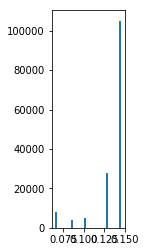

In [214]:
test_pred_y = model.predict(test_x)

import matplotlib.pyplot as plt

plt.interactive(True)

plt.subplot(141)

plt.hist(test_pred_y, 30)





In [215]:
split_point = 0.142

In [216]:
print(test_pred_y.max(), test_pred_y.min(), test_pred_y.mean(), test_pred_y.std())

f1 = sklearn.metrics.f1_score(train_y, [0 if i < split_point else 1 for i in train_pred_y])
print(0.7 * auc + 0.3 * f1, f1)


0.1455305 0.0651083 0.13510607 0.021097058


0.44819454194945235 0.24466158245948522


In [218]:
res = model.predict(test_x)

# np.min(res)
res_min_max = res.copy()
# mean = np.mean(res_min_max)
# std = np.std(res_min_max)
# res_min_max = (res_min_max - mean) / (std)
# np.mean(res)

sub = pd.DataFrame(
    {'EID': merged_test.EID, 'FORTARGET': [0 if i < split_point else 1 for i in res], 'PROB': res_min_max.flatten()})
sub.to_csv("result/result.csv", index=0, float_format='%.4f')
sub.FORTARGET.value_counts()


1    105092
0     44623
Name: FORTARGET, dtype: int64